In [0]:
from fastai.vision import *
from fastai.metrics import *
%matplotlib inline 

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')
#persistent storage

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!wget -cq http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat

In [3]:
!tar xvf 'gdrive/My Drive/fellowship/car_devkit.tgz'

devkit/
devkit/cars_meta.mat
devkit/cars_train_annos.mat
devkit/cars_test_annos.mat
devkit/README.txt
devkit/train_perfect_preds.txt
devkit/eval_train.m


In [0]:
mv devkit gdrive/My\ Drive/fellowship/

In [0]:
import tarfile
import scipy.io
import numpy as np
import cv2 as cv
import os
import shutil
import random

def save_train_data(fnames, labels, bboxes):
    src_folder = 'gdrive/My Drive/fellowship/cars_train/'
    num_samples = len(fnames)
    
    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)
    
    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1-margin)
        y1 = max(0, y1-margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        if i in train_indexes:
            dst_folder = 'gdrive/My Drive/fellowship/cars_dataset/train/'
        else:
            dst_folder = 'gdrive/My Drive/fellowship/cars_dataset/valid/'
            
        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
        
def save_test_data(fnames, bboxes):
    src_folder = 'gdrive/My Drive/fellowship/cars_test/'
    dst_folder = 'gdrive/My Drive/fellowship/cars_dataset/test/'
    num_samples = len(fnames)
    
    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1-margin)
        y1 = max(0, y1-margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
        
def process_train_data():
    cars_annos = scipy.io.loadmat('gdrive/My Drive/fellowship/devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)
    
    fnames = []
    class_ids = []
    bboxes = []
    labels = []
    
    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)
        
    labels_count = np.unique(class_ids).shape[0]
    print('car count: %d' % labels_count)
    
    save_train_data(fnames, labels, bboxes)
    
def process_test_data():
    cars_annos = scipy.io.loadmat('gdrive/My Drive/fellowship/devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)
    
    fnames = []
    bboxes = []
    
    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)
        
    save_test_data(fnames, bboxes)

In [7]:
cars_meta = scipy.io.loadmat('gdrive/My Drive/fellowship/devkit/cars_meta')
class_names = cars_meta['class_names']
class_names = np.transpose(class_names)

img_width, img_height = 224, 224

process_train_data()
process_test_data()


car count: 196


AttributeError: ignored

In [0]:
# path = datapath4file('gdrive/My Drive/fellowship/cars_dataset') #fastai function to get a PosixPath obj
# path_train = path/'train' #train folder with training images organized by class
# path_valid = path/'valid' #validation folder with validation images organized by class

path = 'gdrive/My Drive/fellowship/cars_dataset/'
path_train = path+'train/' 
path_valid = path+'valid/'



In [28]:
bs=64 #batch size

data = ImageDataBunch.from_folder(path, 'train', 'valid', bs=bs) 
data.normalize(imagenet_stats) #normalizing to imagenet, always better to start from somewhere

ImageDataBunch;

Train: LabelList (3794 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0014,0014,0014,0014,0014
Path: gdrive/My Drive/fellowship/cars_dataset;

Valid: LabelList (945 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0106,0106,0106,0106,0106
Path: gdrive/My Drive/fellowship/cars_dataset;

Test: None

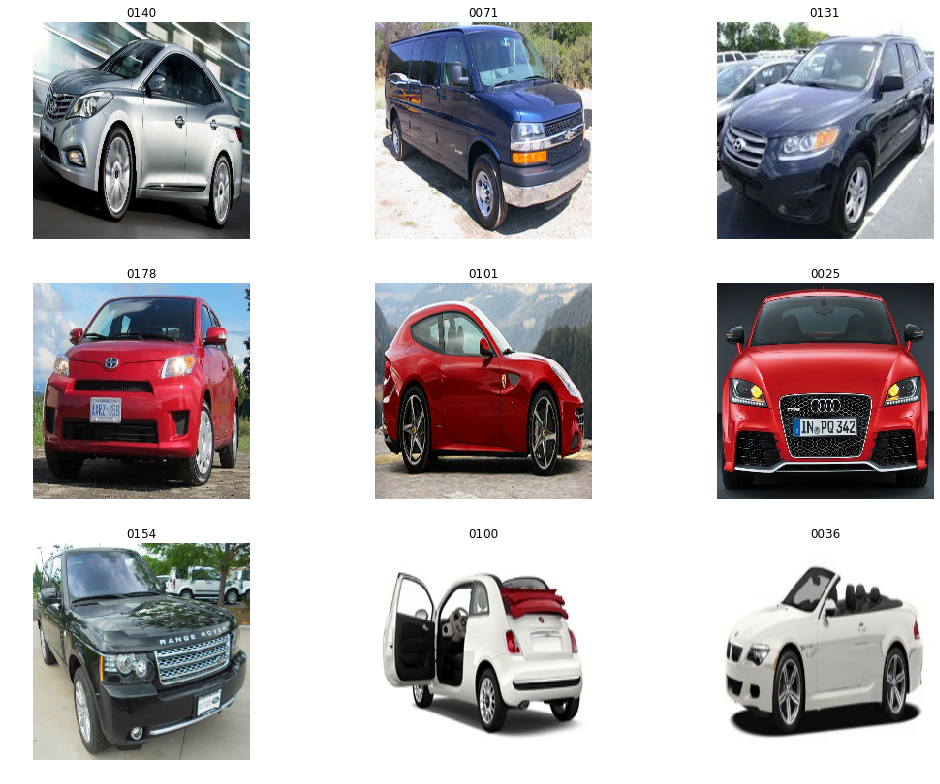

In [13]:
data.show_batch(rows=3, figsize=(15,11))

In [7]:
print(data.classes)

['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125',

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [16]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,5.434145,4.421503,0.120635,12:00
1,4.093565,3.301073,0.279365,00:32
2,2.783700,2.615350,0.361905,00:33
3,1.681077,2.272661,0.433862,00:32
4,0.930493,2.159651,0.468783,00:32
5,0.502946,2.074892,0.496296,00:32
6,0.287688,2.013135,0.504762,00:32
7,0.197789,2.006468,0.504762,00:33


In [0]:
learn.save('../../../fellowship/Resnet50-1')

In [0]:
learn.load('../../../fellowship/Resnet50-1')

In [0]:
learn.freeze()

In [31]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


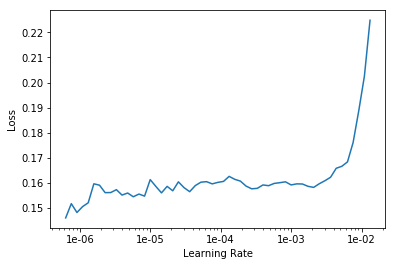

In [32]:
learn.recorder.plot()


In [33]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.209411,1.981475,0.497355,00:46
1,0.642178,2.420181,0.415873,00:44
2,0.859077,1.754999,0.548148,00:44
3,0.488105,1.364674,0.640212,00:44
4,0.218621,1.222957,0.686772,00:45
5,0.096065,1.126164,0.720635,00:44
6,0.042852,1.107110,0.721693,00:44
7,0.025300,1.108222,0.723810,00:44


In [0]:
learn.save('../../../fellowship/Resnet50-2')